# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns


In [25]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [26]:
# frequency table for prestige and whether or not someone was admitted
df.groupby(["admit", "prestige"]).size().reset_index(name="case_count")

,admit,prestige,case_count
0,0,1.0,28
1,0,2.0,95
2,0,3.0,93
3,0,4.0,55
4,1,1.0,33
5,1,2.0,53
6,1,3.0,28
7,1,4.0,12


In [27]:
# frequency table for prestige and whether or not someone was admitted
df[['admit','gre']].groupby('admit').describe()

gre                                                           
       count        mean         std    min    25%    50%    75%    max
admit                                                                  
0      271.0  573.579336  116.052798  220.0  500.0  580.0  660.0  800.0
1      126.0  618.571429  109.257233  300.0  540.0  620.0  680.0  800.0

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [28]:
df.prestige.unique()

array([ 3.,  1.,  4.,  2.])

In [29]:
df2 = pd.get_dummies(data = df, columns = ['prestige'], prefix = 'prestige')

In [30]:
df2.head()

,admit,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: if we have n unique values for a variable, we typically need n-1 class variables

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [31]:
dummy_ranks = df2[['prestige_1.0','prestige_2.0','prestige_3.0','prestige_4.0']]
dummy_ranks.head()

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [32]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df2[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1.0':])
print handCalc.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             0             1             0
1      1  660.0  3.67             0             0             1             0
2      1  800.0  4.00             1             0             0             0
3      1  640.0  3.19             0             0             0             1
4      0  520.0  2.93             0             0             0             1


C:\Users\yifan.zhu\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [33]:
# crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
print pd.crosstab(handCalc['admit'], handCalc['prestige_1.0'], rownames=['admit'])

prestige_1.0    0   1
admit                
0             243  28
1              93  33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [34]:
odds_1 = float(33)/28
print odds_1

1.17857142857


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [35]:
odds_2 = float(93)/(243)
print odds_2

0.382716049383


#### 3.3 Calculate the odds ratio

In [36]:
odds_ratio = odds_1/odds_2
print odds_ratio

3.07949308756


#### 3.4 Write this finding in a sentenance: 

Answer: The odds of being admitted for students attending Rank 1 colleges is 3 times that of students attending non-Rank 1 colleges.

#### 3.5 Print the cross tab for prestige_4

In [37]:
print pd.crosstab(df['admit'], df2['prestige_4.0'], rownames=['admit'])

prestige_4.0    0   1
admit                
0             216  55
1             114  12


#### 3.6 Calculate the OR 

In [38]:
odds_41 = float(15)/55
odds_42 = float(114)/(216)
odds_ratio_4 = odds_41/odds_42
print odds_ratio_4

0.516746411483


#### 3.7 Write this finding in a sentence

Answer: The odds of being admitted for students attending Rank 4 colleges is half of that of students attending non-Rank 4 colleges.

## Part 4. Analysis

In [39]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [40]:
# manually add the intercept
data['intercept'] = 1.0
data.head()

,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,0,380.0,3.61,0,1,0,1.0
1,1,660.0,3.67,0,1,0,1.0
2,1,800.0,4.00,0,0,0,1.0
3,1,640.0,3.19,0,0,1,1.0
4,0,520.0,2.93,0,0,1,1.0


#### 4.1 Set the covariates to a variable called train_cols

In [41]:
train_cols = ['gre', 'gpa','prestige_2.0','prestige_3.0','prestige_4.0','intercept']

In [42]:
data.head()
data.describe()
data.isnull().sum()

admit           0
gre             0
gpa             0
prestige_2.0    0
prestige_3.0    0
prestige_4.0    0
intercept       0
dtype: int64

#### 4.2 Fit the model

In [43]:
logit = sm.Logit(data['admit'], data[train_cols]) 

In [44]:
outcome = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [45]:
print outcome.summary()
print outcome.params

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Sun, 17 Dec 2017   Pseudo R-squ.:                 0.08166
Time:                        00:05:45   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043    7.44e-05       0.004
gpa              0.7793      0.333      2.344      0.019       0.128       1.431
prestige_2.0    -0.6801      0.317     -2.14

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [46]:
print np.exp(outcome.params)

gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
intercept       0.020716
dtype: float64


In [47]:
conf = outcome.conf_int()
conf['OR'] = outcome.params
conf.columns = ['2.5%', '97.5%', 'OR']

In [48]:
conf

,2.5%,97.5%,OR
gre,0.000074,0.004362,0.002218
gpa,0.127619,1.431056,0.779337
prestige_2.0,-1.301337,-0.058936,-0.680137
prestige_3.0,-2.014579,-0.662776,-1.338677
prestige_4.0,-2.371624,-0.735197,-1.553411
intercept,-6.116077,-1.637631,-3.876854


In [49]:
print np.exp(conf)

                  2.5%     97.5%        OR
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525
intercept     0.002207  0.194440  0.020716


In [50]:
# check for accuracy and roc scores

from sklearn import metrics
print metrics.roc_auc_score(y_true=data['admit'], y_score=outcome.predict(data[train_cols]))
metrics.accuracy_score(y_true=data['admit'], y_pred=(outcome.predict(data[train_cols])>0.5))

# not bad

0.690300474433


0.70780856423173799

[(0, 1),
 Text(0,0.5,u'TRP'),
 (0, 1),
 Text(0.5,0,u'FRP'),
 Text(0.5,1,u'Area Under the Curve for prediction delayed=1')]

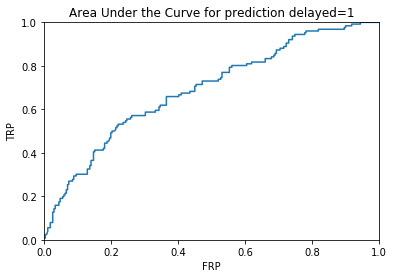

In [53]:
ax = plt.subplot(111)
vals = metrics.roc_curve(data['admit'], outcome.predict(data[train_cols]))
ax.plot(vals[0], vals[1])
ax.set(title='Area Under the Curve for prediction delayed=1', ylabel='TRP',
xlabel='FRP', xlim=(0, 1), ylim=(0, 1))

#### 4.5 Interpret the OR of Prestige_2

Answer: The odds ratio of people from prestige 2 colleges in comparison to people from prestige 1 colleges is about 0.5.

#### 4.6 Interpret the OR of GPA

Answer: Increasing one unit of GPA score will increase the odds of being admitted to 2.18 multiplying the initial odds

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [104]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [105]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [106]:
combos.head()

,0,1,2,3
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [107]:
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
combos.head()

,gre,gpa,prestige,intercept
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


In [108]:
# recreate the dummy variables
# keep only what we need for making predictions


df3 = pd.get_dummies(data = combos, columns = ['prestige'], prefix = 'prestige', drop_first = True)
df3.head()

,gre,gpa,intercept,prestige_2.0,prestige_3.0,prestige_4.0
0,220.0,2.260000,1.0,0,0,0
1,220.0,2.260000,1.0,1,0,0
2,220.0,2.260000,1.0,0,1,0
3,220.0,2.260000,1.0,0,0,1
4,220.0,2.453333,1.0,0,0,0


#### 5.2 Make predictions on the enumerated dataset

In [113]:
df3['admit_est'] = outcome.predict(df3[train_cols])

In [114]:
print df3.tail()

       gre       gpa  intercept  prestige_2.0  prestige_3.0  prestige_4.0  \
395  800.0  3.806667        1.0             0             0             1   
396  800.0  4.000000        1.0             0             0             0   
397  800.0  4.000000        1.0             1             0             0   
398  800.0  4.000000        1.0             0             1             0   
399  800.0  4.000000        1.0             0             0             1   

     admit_est  
395   0.334286  
396   0.734040  
397   0.582995  
398   0.419833  
399   0.368608  


#### 5.3 Interpret findings for the last 4 observations

Answer: They have the same gre and gpa scores, so the probability of being admitted is positively correlated with the prestige of their colleges. The person whose college prestige is 1 has the highest probability of being admitted.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.